## About

We take reliability extremely seriously at Empiric Network. Here is an overview of our performance the last ~3 weeks, all based on data publicly available on the blockchain (see this script if you'd like to run yourself: https://github.com/42labs/Empiric/blob/master/analytics/crawl_events.py).

We go through overall performance, identify anomalies and provide context on those - why they happened, and in the one case where it was not due to StarkNet halting block production, how we are addressing the root cause going forward.

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

In [71]:
df = pd.read_csv("empiric-events.csv")
df = df.drop(columns="Unnamed: 0")
df["datetime"] = pd.to_datetime(df["datetime"])
df.head()

,key,value,source,publisher,timestamp,transaction_hash,datetime
0,btc/usd,19562.40,coingecko,pontis,1657038016,5595418886240581305375025138423424250179008318...,2022-07-05 16:20:16
1,btc/eur,19098.24,coingecko,pontis,1657038016,5595418886240581305375025138423424250179008318...,2022-07-05 16:20:16
2,eth/usd,1094.30,coingecko,pontis,1657038001,5595418886240581305375025138423424250179008318...,2022-07-05 16:20:01
3,sol/usd,33.88,coingecko,pontis,1657038071,5595418886240581305375025138423424250179008318...,2022-07-05 16:21:11
4,avax/usd,16.99,coingecko,pontis,1657038001,5595418886240581305375025138423424250179008318...,2022-07-05 16:20:01


In [ ]:
eth_data = df[df["key"] == "eth/usd"]
eth_data["transaction_hash"] = eth_data["transaction_hash"].apply(lambda x: hex(int(x)))

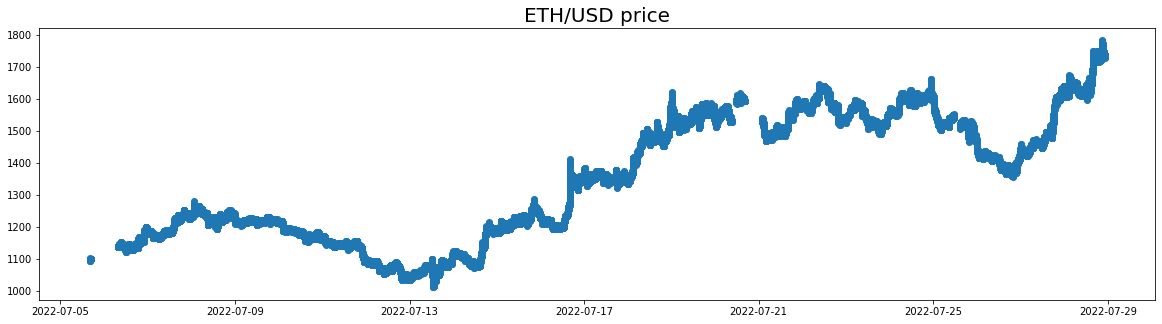

In [142]:
plt.figure(figsize=(20, 5))
plt.scatter(eth_data["datetime"], eth_data["value"])
plt.title("ETH/USD price", fontsize=20)
plt.show()

In [134]:
eth_data = eth_data.sort_values("datetime")
eth_data["previous_datetime"] = eth_data.shift(1)["datetime"]
eth_data["time_diff"] = eth_data["datetime"] - eth_data["previous_datetime"]
eth_data["seconds_diff"] = eth_data["time_diff"].apply(lambda x: x.seconds)

In [140]:
eth_data["seconds_diff"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999])

count    132729.000000
mean         15.132759
std         180.791870
min           0.000000
25%           0.000000
50%           3.000000
75%           8.000000
90%          51.000000
95%          83.000000
99%         142.000000
99.9%       212.272000
max       53047.000000
Name: seconds_diff, dtype: float64

## Takeaway

The majority of updates happens within a few seconds of the last update. The worst 0.1% of updates take ~3.5 minutes between updates.

Let's investigate every single case where data updating took a long time. Let's look at the time (in seconds) between updates:

In [125]:
eth_data[eth_data["seconds_diff"] > 1200]

,key,value,source,publisher,timestamp,transaction_hash,datetime,previous_datetime,time_diff,seconds_diff
353,eth/usd,1138.640,coinbase,pontis,1657092180,0x7fb11e569a509b8b7aa2fb6b91059eec6c0e9589dae1...,2022-07-06 07:23:00,2022-07-05 16:38:53,0 days 14:44:07,53047.0
1021556,eth/usd,1347.640,coinbase,equilibrium,1658065980,0x31bd64db4223626af06bb33f8457e1e81d895b94b246...,2022-07-17 13:53:00,2022-07-17 13:15:39,0 days 00:37:21,2241.0
1025038,eth/usd,1350.670,coinbase,pontis,1658073300,0x3b2ae9b2e3229aeb2b6f01da26b27af796cb58063c6a...,2022-07-17 15:55:00,2022-07-17 14:37:38,0 days 01:17:22,4642.0
1334607,eth/usd,1598.250,coingecko,empiric,1658315847,0x436776591febfb4a7048a5e2bc87fab7c2d6fcb0fc57...,2022-07-20 11:17:27,2022-07-20 09:02:42,0 days 02:14:45,8085.0
1341977,eth/usd,1537.690,coinbase,pontis,1658367900,0x25e345b2da76c33b340876ec61bb4d08a7ff183b0617...,2022-07-21 01:45:00,2022-07-20 16:12:44,0 days 09:32:16,34336.0
1496102,eth/usd,1536.610,coinbase,pontis,1658741040,0x1aabf1adeb11e98214e6f7cfaf79bb12a3afef8efe4d...,2022-07-25 09:24:00,2022-07-25 08:57:36,0 days 00:26:24,1584.0
1499000,eth/usd,1509.935,coinbase,pontis,1658759400,0x623520fb4ea20dca8314db4342e73d41018635b72c07...,2022-07-25 14:30:00,2022-07-25 11:17:37,0 days 03:12:23,11543.0


## Context

### ID 353

New oracle contract was not fully deployed yet, still in testing (old one was still up and running).

### ID 1021556

StarkNet block production was interrupted. See transaction hash that confirms transaction failed because it was processed more than an hour after being sent: 

https://alpha4.starknet.io/feeder_gateway/get_transaction_receipt?transactionHash=0x31bd64db4223626af06bb33f8457e1e81d895b94b246614e1ffc6e4f4766fdf

### ID 1025038

StarkNet block production ceased. See blocks 270232

(https://goerli.voyager.online/block/0x4ab8df360db263c38952a70eb982de55ce6ebcbfc17fcb74da9e7fe1adad93f)

and 270233

(https://goerli.voyager.online/block/0x69192af2804f10281fb32df5d403bb6e74486f0c6f3972a9baa88592e283d1c)

### ID 1334607

StarkNet upgraded to Cairo 0.9.1, breaking both the starknet.py and starknet.js SDKs. Our alerts picked up on it and we patched manually. We have agreed on better processes for breaking change releases with StarkWare and will deploy on their integration network in order to have earlier notice next time.

### ID 1341977

StarkNet block production ceased. See blocks 273104

(https://goerli.voyager.online/block/0x163f580b43d2b6059b26d6bf75739b30f33f43e19721baa605805daed131ff0)

and 273103

(https://goerli.voyager.online/block/0x1187a1ff3f96f9188a0d3f440131fc6cb6803e05966dae2f4bc82e65af2ed71)

### ID 1496102

StarkNet block production was interrupted. See transaction hash that confirms transaction failed because it was processed more than an hour after being sent: 

https://alpha4.starknet.io/feeder_gateway/get_transaction_receipt?transactionHash=0x1aabf1adeb11e98214e6f7cfaf79bb12a3afef8efe4db553f12260f22b0fe01

### ID 1499000

StarkNet block production ceased. See blocks 277167

(https://goerli.voyager.online/block/0x2e9a40f4e77a9a24a882f371af80a21f1a3b027080aa35ae8cbfd5d9124b297)

and 277168

(https://goerli.voyager.online/block/0x41f1ff9dfd1511c64099c7206301d35b9c247ed2561a350223e126279eda42c)